In [11]:
import time
from matplotlib import pyplot as plt
import numpy as np
from pysmartworkcell.ArucoDetection import ArucoDetection
from pysmartworkcell import (
    calibration_utils as calib_utils,
    realsense_utils as rs_utils
)
import pyrealsense2 as rs
from pyrealsense2 import camera_info
import cv2

def detect(dict: int, marker_len: float, calib_path: str):
    pkg_root = calib_utils.find_pkg_path()
    # cam_mtx, dist_coeffs = calib_utils.load_camera_intrinsic(calib_path)
    # detectNode = ArucoDetection(
    #     dict, cam_matrix=cam_mtx, dist_coeffs=dist_coeffs, marker_length=marker_len
    # )
    pipeline, config = rs_utils.initialize_realsense_camera()
    colorizer = rs.colorizer()
    try:
        pipeline.start(config)
        time.sleep(2)
        profile = pipeline.get_active_profile()
        device = profile.get_device()
        print(f'Streaming device: {device.get_info(camera_info.name)}\
            serial number: {device.get_info(camera_info.serial_number)}')
        while profile is not None:
            frames = pipeline.wait_for_frames()
            color_frame = frames.get_color_frame()
            depth_frame = frames.get_depth_frame()
            if not color_frame or not depth_frame:
                continue
            
            # Convert frame to np arrays
            color_img = np.asanyarray(color_frame.get_data())
            depth_img = np.asanyarray(colorizer.colorize(depth_frame).get_data())
            depth16 = np.asanyarray(depth_frame.get_data())

            image_concat = np.hstack((color_img, depth_img))
            cv2.imshow('rgb+depth', image_concat)
            
            # Save image and depth
            key = cv2.waitKey(1)
            if key == ord('s'):
                cv2.imwrite('../../io/color.png', color_img)
                np.save('../../io/depth.npy', depth16)
                print(f'Image & Depth are saved.')
            if key == ord('q'):
                break
            
            # Detect aruco marker
            # success, ids, T_list = detectNode.estimate_maker_pose_from_frame(color_img)
            # if success:
            #     print('Markers found! Compute transformation matrices...')
            #     save_path = pkg_root/'config'/'cam2marker.yaml'
            #     calib_utils.save_transform_mtx(ids, T_list=T_list, path=save_path)
            #     return success, ids, T_list
    except Exception as e:
        raise e
    finally:
        pipeline.stop()
        cv2.destroyAllWindows()
        print('RealSense camera shutdown successfully!')

detect(cv2.aruco.DICT_4X4_50, 0.01, '')


project_root: /home/non/nhan_ws/src/smartworkcell
[INFO] 1 RealSense device(s) connected.

[0] Intel RealSense D435
    Serial Number: 819312070131
    Firmware: 5.17.0.10
Streaming device: Intel RealSense D435            serial number: 819312070131
Image & Depth are saved.
RealSense camera shutdown successfully!


In [12]:
from pysmartworkcell.vlm_utils import (
    load_models, 
    predict_and_annotate, 
    estimate_axes_from_pcl, draw_and_show_axes,
    get_pcl_from_mask, axes2matrix
)
from pysmartworkcell import (
    calibration_utils as calib_utils,
    vlm_utils, 
    realsense_utils as rs_utils
)
import yaml
from PIL import Image
import numpy as np
import torch
import cv2
import supervision as sv
import matplotlib.pyplot as plt

In [13]:
from pathlib import Path

current_path = Path.cwd()

# Search upward for the folder named "SmartWorkcell"
for parent in current_path.parents:
    if (parent / "config").exists() and (parent / "src").exists():
        PROJECT_ROOT = parent
        break
else:
    raise RuntimeError("SmartWorkcell root not found")

DEVICE = 'cuda'
CONFIG_DIR = PROJECT_ROOT / "config"
IO_DIR = PROJECT_ROOT / "io"
SRC_DIR = PROJECT_ROOT / "src"
print(f'config dir: {CONFIG_DIR}\nio dir: {IO_DIR}\nsrc dir: {SRC_DIR}')


config dir: /home/non/nhan_ws/src/smartworkcell/config
io dir: /home/non/nhan_ws/src/smartworkcell/io
src dir: /home/non/nhan_ws/src/smartworkcell/src


In [14]:
# Load gdino & sam predictor
gdino, predictor = load_models(
    gdino_checkpoint='../../config/gdino/weights/groundingdino_swinb_cogcoor.pth',
    gdino_config='../../config/gdino/GroundingDINO_SwinB_cfg.py',
    sam_image_encoder='../../config/nanosam/resnet18_image_encoder.engine',
    sam_mask_decoder='../../config/nanosam/mobile_sam_mask_decoder.engine'
)

final text_encoder_type: bert-base-uncased


[10/21/2025-17:18:34] [TRT] [W] WARNING The logger passed into createInferRuntime differs from one already registered for an existing builder, runtime, or refitter. So the current new logger is ignored, and TensorRT will use the existing one which is returned by nvinfer1::getLogger() instead.
[10/21/2025-17:18:34] [TRT] [W] WARNING The logger passed into createInferRuntime differs from one already registered for an existing builder, runtime, or refitter. So the current new logger is ignored, and TensorRT will use the existing one which is returned by nvinfer1::getLogger() instead.


[10/21/2025-17:19:39] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[10/21/2025-17:19:39] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.


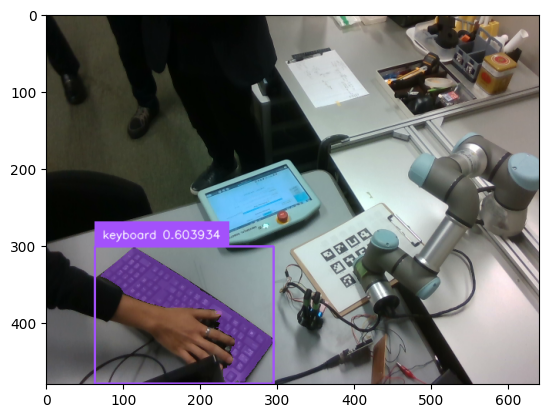

In [15]:
IMAGE = IO_DIR / "color.png"
TEXT = 'teach pendant. keyboard. water bottle'

labels, bboxes, results = predict_and_annotate(gdino, predictor, IMAGE, TEXT)

In [16]:
# load depth
DEPTH = IO_DIR / 'depth.npy'
depth = np.load(DEPTH)

# Load camera matrix
with open(CONFIG_DIR / 'd435_origin.yaml') as f:
    data = yaml.safe_load(f)
cam_mtx = np.array(data['camera_matrix'], dtype=np.float32)
depth_scale = float(data['depth_scale'])

obj_list = []
for result in results:
    mask = result['segmentation']
    pcl = get_pcl_from_mask(mask, depth, cam_mtx=cam_mtx, depth_scale=depth_scale)
    axes, centroid = estimate_axes_from_pcl(pcl)
    obj = {
        'pcl': pcl,
        'axes': axes,
        'centroid': centroid,
        'T_cam_obj': axes2matrix(axes=axes, centroid=centroid) # obj pose in cam (transformation mtx from camera to obj)
    }
    obj_list.append(obj)

In [17]:
axes_list = [obj['axes'] for obj in obj_list]
pcl_list = [obj['pcl'] for obj in obj_list]

In [18]:
draw_and_show_axes(pcl_list=pcl_list, axes_list=axes_list, axis_length=0.4)

In [9]:
# Compute object pose in robot frame
T_cam_obj_list = [obj['T_cam_obj'] for obj in obj_list]
ids, T_list_cam_robot = calib_utils.load_transform_mtx(CONFIG_DIR / 'cam2robot.yaml')
T_robot_cam_list = [calib_utils.invert_transform(T) for T in T_list_cam_robot]
T_robot_obj_list = [T_rc @ Tco for T_rc, Tco in zip(T_robot_cam_list, T_cam_obj_list)]
calib_utils.save_transform_mtx(ids=ids, T_list=T_robot_obj_list, path=CONFIG_DIR/'robot2obj.yaml')

[INFO] Saved transforms to /home/non/nhan_ws/src/smartworkcell/config/robot2obj.yaml


In [10]:
poses = [calib_utils.matrix2pose(T) for T in T_robot_obj_list]
poses

[position: 
   x: 0.7196285719790791
   y: 0.5223423351983305
   z: 0.5210859354092544
 orientation: 
   x: -0.3727629657446303
   y: 0.5521432180077829
   z: -0.037253710068511046
   w: 0.7448475006760842]